# Nome chique
* Supplementaty material to the work ``Blá`` submitted to CNMAC.
 * Authors: Guilherme, Fabio, Matheus, and Esequia.

* In this notebook, we illustrate the usage of the implementation and present comparisons of the results produced by our routine with values obtained by directed integration with multiple precision aritmethics, and those calculated my Maplesoft 15.


In [26]:
from mpmath import mp
import matplotlib.pyplot as plt
import numpy as np
import ctypes

spectral = ctypes.CDLL('./spectral_coef.so')
spectral.spectral_method_coef.restype = ctypes.c_double
spectral.spectral_method_coef.argtypes = [ctypes.c_uint, ctypes.c_double, ctypes.c_double]
# The function has the following signature:
# double spectral_method_coef(unsigned int k, double alpha, double deltax)

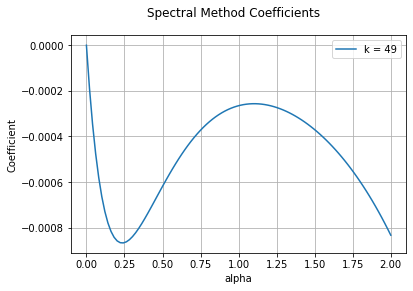

In [27]:
k = 49
deltax = 1.0
fig, ax = plt.subplots()
alpha_range = np.linspace(0, 2, 100)
y = np.array([spectral.spectral_method_coef(k, x, deltax) for x in alpha_range])
ax.plot(alpha_range, y, label=f'k = {k}')
plt.suptitle('Spectral Method Coefficients')
plt.xlabel('alpha')
plt.ylabel('Coefficient')
plt.legend()
plt.grid()
plt.show()

#### Python function to calculate the coefficients
<!-- $$
\begin{align*}
\mu_k &= \frac{1}{\pi h^{\alpha}}\int_0^\pi x^\alpha \cos(k x)dx\\
&= \frac{1}{\pi k^{\alpha+1} h^{\alpha}}\int_0^{k\pi} x^\alpha \cos(x)dx\\
&=\frac{1}{\pi k^{\alpha+1} h^{\alpha}}\sum_{n=0}^{k-1}\int_{n\pi}^{(n+1)\pi} x^\alpha \cos(x)dx\\
&=\frac{1}{\pi k^{\alpha+1} h^{\alpha}}\sum_{n=0}^{k-1}(-1)^k\int_{0}^{\pi} (x+k\pi)^\alpha \cos(x)dx\\
&=\frac{1}{\pi k^{\alpha+1} h^{\alpha}}\sum_{n=0}^{k-1}(-1)^k\int_{0}^{\pi/2}\left[ (k\pi-x)^\alpha -  (k\pi + (\pi-x))^\alpha\right]\cos(x)dx
\end{align*}
$$ -->
$$
\mu_k := \frac{1}{\pi h^{\alpha}}\int_0^\pi x^\alpha \cos(k x)dx
=\frac{1}{\pi k^{\alpha+1} h^{\alpha}}\int_{0}^{\pi/2}f(x)\cos(x)dx,
$$
where
$$f(x)=\sum_{n=0}^{k-1}(-1)^k\left[ (k\pi-x)^\alpha -  (k\pi + (\pi-x))^\alpha\right].$$ 

In [28]:
mp.dps = 25
def coeff_mp(k, alpha_, deltax_):
    """
    Compute the numerical quadrature using mpmath.

    Parameters
    ----------
    k : int
        The number of terms in the sum.
    alpha_ : float
        The value of alpha.
    deltax_ : float
        The value of deltax.

    Returns
    -------
    mu_mp : mpf
        The value of the coefficient.
    """
    def integrand(x):
        """
        The integrand for the numerical quadrature.

        The integrand is rewritten to avoid numerical issues with the oscillatory
        behavior of the integrand.
        """
        E = 0
        for n in range(k-1, 0, -1):
            sgn = 1 if n % 2 == 0 else -1
            l1 = mp.expm1(alpha * mp.log1p(x / (n * mp.pi)))
            l2 = mp.expm1(alpha * mp.log1p((mp.pi - x) / (n * mp.pi)))
            ll = l1 - l2
            E += sgn * ll * (n*mp.pi) ** alpha
        E += mp.expm1(mp.log(x) * alpha) - mp.expm1(mp.log(mp.pi - x) * alpha)
        return E * mp.cos(x)

    alpha = mp.mpmathify(alpha_)
    deltax = mp.mpmathify(deltax_)

    while True:
        # Compute the integral
        I_mp, error = mp.quad(integrand, [0, mp.pi/2], error=True)
        # The number of digits is increased until the error is small enough
        if error > 1e-25:
            mp.dps += 2
            continue
        elif error < 1e-40 and mp.dps > 25:
            mp.dps -= 1
        break
    mu_mp = (k * deltax)**(-alpha) * I_mp / (k * mp.pi)
    return mu_mp

In [8]:
# Based on Boost library
def ULPs(precise, approx):
    """
    Calculate the number of ULPs between two floating point numbers.

    Parameters
    ----------
    precise : float
        The precise value.
    approx : float
        The approximate value.

    Returns
    -------
    ulp : float
        The number of ULPs between the two values.
    """
    y_hi_acc = precise
    y_lo_acc = type(precise)(approx)
    
    absy = abs(y_hi_acc)
    absy_lo = type(approx)(absy)
    dist = type(precise)(np.nextafter(absy_lo, absy_lo + 1) - absy_lo)
    ulp = type(approx)((y_lo_acc - y_hi_acc)/dist)
    return ulp

In [41]:
k = 14
deltax = 1

alpha = mp.mpmathify(112)/100

print(spectral.spectral_method_coef(k, alpha, deltax))
print(coeff_mp(k, alpha, deltax))
ULPs(coeff_mp(k, alpha, deltax), spectral.spectral_method_coef(k, alpha, deltax))

0.0008585783209249228
0.0008585783209249217404921333


10.185256525292061

25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25
25


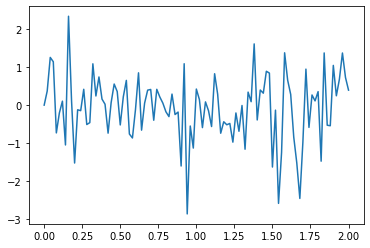

In [26]:
k = 9
deltax = 1.0
def error(alpha):
    return ULPs(coeff_mp(k, alpha, deltax), spectral.spectral_method_coef(k, alpha, deltax))

v_alpha = np.linspace(0, 2, 101)
coeffs = np.array([error(alpha) for alpha in v_alpha])


fig, ax = plt.subplots()
ax.plot(v_alpha, coeffs, label=f'k = {k}')

plt.show()


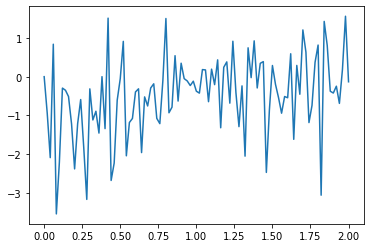

In [28]:
k = 11

deltax = 1.0
def error(alpha):
    return ULPs(coeff_mp(k, alpha, deltax), spectral.spectral_method_coef(k, alpha, deltax))

v_alpha = np.linspace(0, 2, 101)
coeffs = np.array([error(alpha) for alpha in v_alpha])


fig, ax = plt.subplots()
ax.plot(v_alpha, coeffs, label=f'k = {k}')

plt.show()


0.0 36
4.9406564584124654417656879286822137e-324
1.0e-47 35
5.4210108624275221700372640043497086e-20
1.0e-47 35
1.0842021724855044340074528008699417e-19
1.0e-46 35
2.1684043449710088680149056017398834e-19
1.0e-46 35
2.1684043449710088680149056017398834e-19
1.0e-46 35
2.1684043449710088680149056017398834e-19
1.0e-46 35
2.1684043449710088680149056017398834e-19
1.0e-45 35
4.3368086899420177360298112034797668e-19
1.0e-45 35
4.3368086899420177360298112034797668e-19
1.0e-45 35
4.3368086899420177360298112034797668e-19
1.0e-45 35
4.3368086899420177360298112034797668e-19
1.0e-45 35
4.3368086899420177360298112034797668e-19
1.0e-45 35
4.3368086899420177360298112034797668e-19
1.0e-45 35
4.3368086899420177360298112034797668e-19
1.0e-45 35
4.3368086899420177360298112034797668e-19
1.0e-44 35
4.3368086899420177360298112034797668e-19
1.0e-44 35
4.3368086899420177360298112034797668e-19
1.0e-44 35
4.3368086899420177360298112034797668e-19
1.0e-44 35
4.3368086899420177360298112034797668e-19
1.0e-44 35
4.33

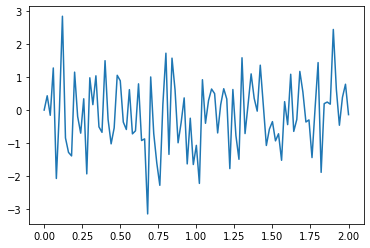

In [ ]:
k = 21
# mp.dps = 80
deltax = 1.0
def error(alpha):
    return ULPs(coeff_mp(k, alpha, deltax), spectral.spectral_method_coef(k, alpha, deltax))

v_alpha = np.linspace(0, 2, 101)
coeffs = np.array([error(alpha) for alpha in v_alpha])


fig, ax = plt.subplots()
ax.plot(v_alpha, coeffs, label=f'k = {k}')

plt.show()


In [38]:
error_in_ULPs = []
with open("/home/fabio/saida.txt", 'r') as f:
    for i, line in enumerate(f.readlines()):
        k, alpha, mu_ref_str = line.split(',')
        if float(alpha) == 0 or float(alpha) == 1 and int(k) % 2 == 0:
            mu_ref = mp.mpmathify(0)
        else:
            mu_ref = mp.mpmathify(mu_ref_str)
        mu_test = spectral.spectral_method_coef(int(k), float(alpha), 1.0)
        error = ULPs(mu_ref, mu_test)
        error_in_ULPs.append(error)
        if error > 10:
            print(f"l = {k}, alpha = {alpha}, ref = {mu_ref}, test = {mu_test}, erro = {error}")
        #if i > 10:
        #    break
error_in_ULPs = np.array(error_in_ULPs)
print(error_in_ULPs.min(), error_in_ULPs.max(), error_in_ULPs.mean(), abs(error_in_ULPs).mean())

l = 14, alpha =  1.12000000000000000000000000000000000000000000000000e+00, ref = 0.0008585783209249217404921333, test = 0.0008585783209249228, erro = 10.185256525408477
l = 28, alpha =  1.12000000000000000000000000000000000000000000000000e+00, ref = 0.0002391313443040909576461328, test = 0.00023913134430409124, erro = 10.571202171267942
-9.960445808363147 10.571202171267942 -0.029508819042400707 1.26370162939103


In [24]:
def compare_maple(k):
    error_in_ULPs = []
    with open(f"/home/fabio/Ikmaple_{k:03d}.dat") as f:
        for line in f.readlines():
            alpha, mu_ref_str = line.split(',')
            alpha_float = float(alpha)
            mu_ref = mp.mpmathify(mu_ref_str)
            mu_test = spectral.spectral_method_coef(k, alpha_float, 1.0)
            error = ULPs(mu_ref, mu_test)
            error_in_ULPs.append(error)
            # if abs(error) > 4:
            #     print(f"l = {k}, alpha = {alpha}, ref = {mu_ref}, test = {mu_test}, erro = {error}")
            #     alpha_mp = mp.mpmathify(alpha_float)
            #     mu_ref_2 = coeff_mp(k, alpha_mp, 1.0)
            #     error_2 = ULPs(mu_ref_2, mu_test)
            #     print(f"l = {k}, alpha = {alpha}, ref = {mu_ref}, test = {mu_test_2}, erro = {error_2}")
    return np.array(error_in_ULPs)


error_in_ULPs = compare_maple(100)
print(error_in_ULPs.min(), error_in_ULPs.max(), error_in_ULPs.mean(), abs(error_in_ULPs).mean(), len(error_in_ULPs))        

-3.548883164068684 6.104751837905496 0.4372072454034992 1.0288611532768641 2048


In [25]:
for k in range(1, 101):
    error_in_ULPs = compare_maple(k)
    print(k, error_in_ULPs.min(), error_in_ULPs.max(), error_in_ULPs.mean(), abs(error_in_ULPs).mean(), len(error_in_ULPs))

1 -7.558609277242795 3.5925113038392738 -0.6667105369405135 1.062565000535983 2048
2 -5.260983696905896 4.2810126973781735 -0.16908098239548508 1.0893991710477167 2048
3 -4.527857060194947 3.744390976498835 -0.4756874776001041 0.8915679894566892 2048
4 -3.5717662174720317 3.2153471963247284 -0.16800869969853238 0.7512419063518223 2048
5 -3.6636110697872937 3.234997981810011 -0.37326465752965987 0.8195723836079765 2048
6 -3.410436548991129 3.599301016307436 -0.16241558292057334 0.7897977588519893 2048
7 -3.6067424457287416 3.416621017619036 -0.33522520239318965 0.8458131682364183 2048
8 -3.7480003635864705 4.4581585304113105 -0.14984318698805055 0.8882388970328066 2048
9 -3.5350105261895806 3.312950475839898 -0.1137061799884691 0.7172344198990572 2048
10 -4.100578834302723 3.8851486317580566 -0.008986369551621465 0.8056599368579782 2048
11 -3.5920604990096763 3.9932896880200133 -0.3565448539838485 0.8122035731366282 2048
12 -5.033121253945865 3.7630778815364465 -0.22542679627127882 0.88